In [35]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install sktime

Note: you may need to restart the kernel to use updated packages.


## Стационарность

In [2]:
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV

from sktime.utils.plotting import plot_correlations

from statsmodels.tsa.stattools import kpss

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)

In [6]:
from pandas import read_csv, DataFrame
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
#import ml_metrics as metrics
data = pd.read_csv('Custom_location.csv')

In [42]:
data['dt_iso'] 

0         1979-01-01 00:00:00 +0000 UTC
1         1979-01-01 01:00:00 +0000 UTC
2         1979-01-01 02:00:00 +0000 UTC
3         1979-01-01 03:00:00 +0000 UTC
4         1979-01-01 04:00:00 +0000 UTC
                      ...              
401467    2024-10-18 19:00:00 +0000 UTC
401468    2024-10-18 20:00:00 +0000 UTC
401469    2024-10-18 21:00:00 +0000 UTC
401470    2024-10-18 22:00:00 +0000 UTC
401471    2024-10-18 23:00:00 +0000 UTC
Name: dt_iso, Length: 401472, dtype: object

In [8]:
data = pd.read_csv('Custom_location.csv').tail(365*24).head(365*24 - 8)
data_test = pd.read_csv('Custom_location.csv').tail(8)
y1 = data['humidity']
y1_test = data_test['humidity']


In [10]:
from pandas import read_csv, DataFrame
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
#import ml_metrics as metrics

y1.index = pd.date_range(start="2023-10-20 00:00", end = '2024-10-18 15:00', freq="h").to_period()
sm.tsa.adfuller(y1)

#ряд не стационарен по KPSS тесту, это исправляется через дифференцирование. 
#Логарифм не очень в этом помог

(-6.842719933401539,
 1.7743307339763688e-09,
 36,
 8715,
 {'1%': -3.4311005711015787,
  '5%': -2.86187170239314,
  '10%': -2.566946560220062},
 44968.10532835284)

In [14]:
from sktime.utils.plotting import plot_correlations

from statsmodels.tsa.stattools import kpss
print(kpss(y1))
print(kpss(y1.diff().dropna()))

(7.5542277414069625, 0.01, 49, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.0027225769835691888, 0.1, 19, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/var/folders/cf/qjtl4dw56hdg9z767sd01yb40000gn/T/ipykernel_5176/2401701247.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(kpss(y1))
/var/folders/cf/qjtl4dw56hdg9z767sd01yb40000gn/T/ipykernel_5176/2401701247.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(kpss(y1.diff().dropna()))


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='humidity'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

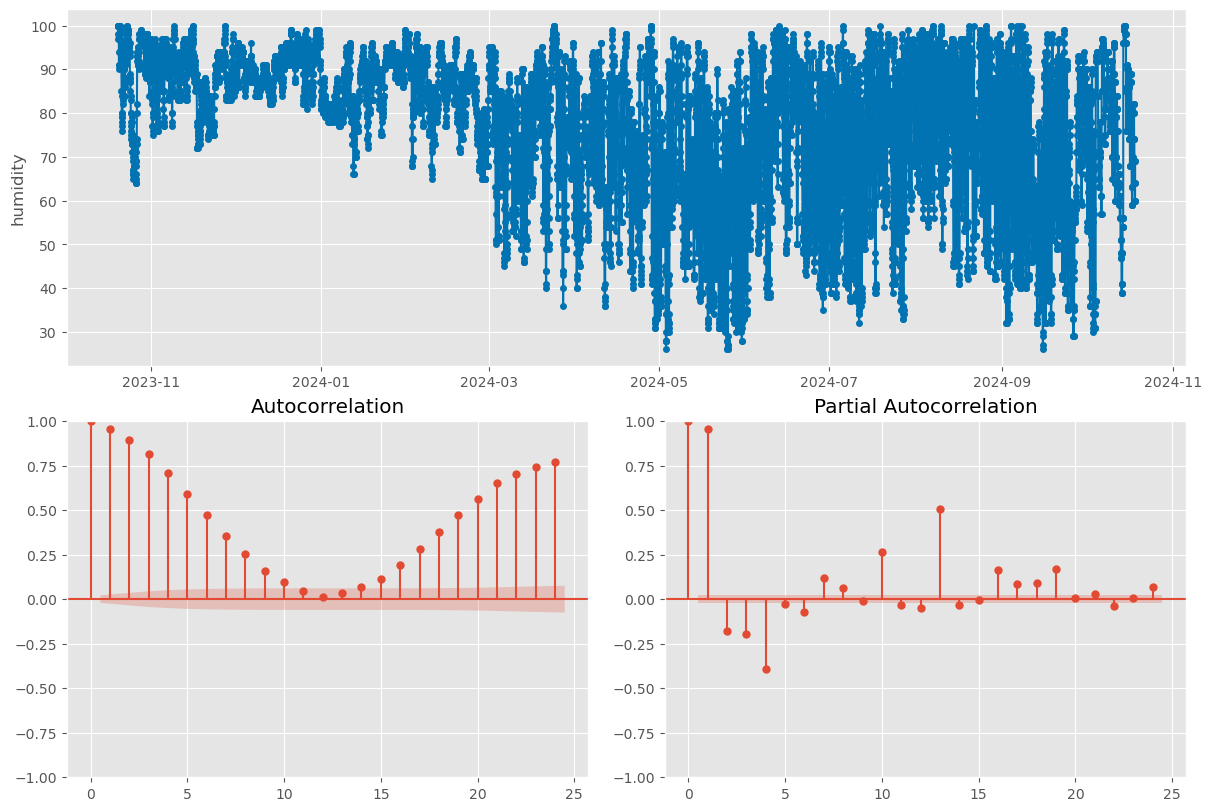

In [154]:
# посмотрим на визуализацию ряда, acf, pacf 
plot_correlations(y1)

In [ ]:
# по графику видно, что ряд не стационарен
# попробуем дифференцировать его

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='humidity'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

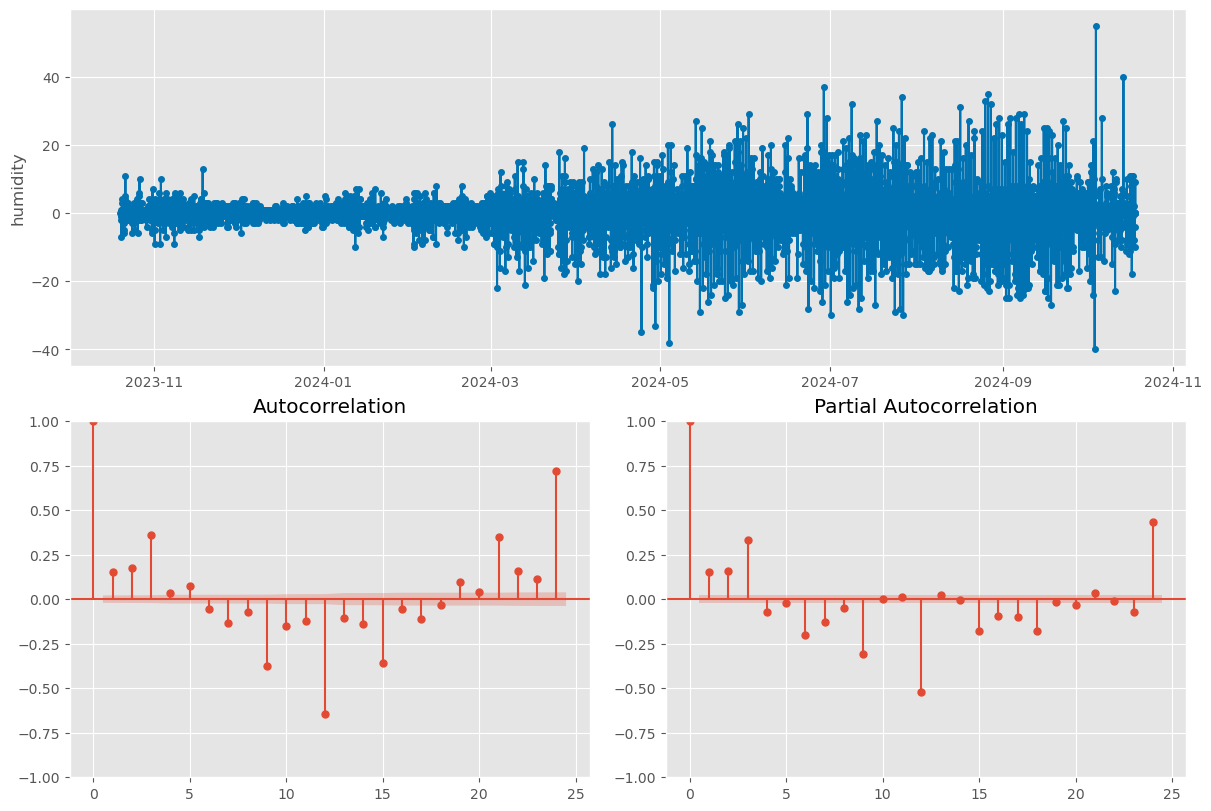

In [156]:
plot_correlations(y1.diff().dropna())

In [ ]:
# по графику видно, что после дифференцирования ряд стал лучше в плане стационарности
# посмотрим также на эффект от логарифмирования

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='humidity'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

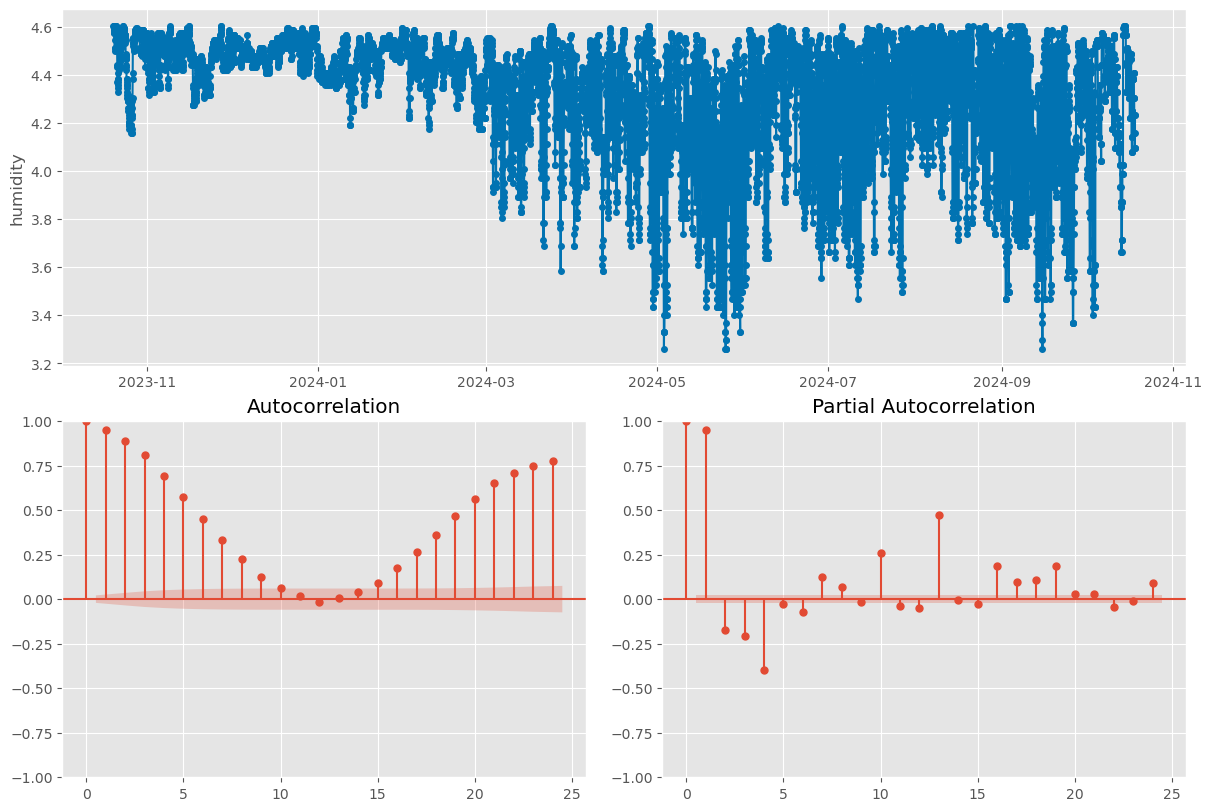

In [158]:
plot_correlations(np.log(y1))
# логарифмирвание, как говорилось ранее, не помогло в плане стационарности

## Моделирование

In [166]:
# подберем гиперпараметры ARIMA через перебор параметров
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
            
cv = SlidingWindowSplitter(
    start_with_window=True,
    initial_window=300,
    fh=list(range(1, 9)),
    step_length= 24)

forecaster = ARIMA()

# ограничимся p, q <= 3 исходя из графиков выше. При значениях p,q = 2 gs падает
param_grid = {"order" : [(1,1,1),(1,0,1),(3,1,3),(3,0,3)], 
              'enforce_stationarity': [False]
             }

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    error_score='raise',
    scoring=mean_absolute_percentage_error
    )

gscv.fit(y1)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8],
                                                 initial_window=300,
                                                 step_length=24),
                        error_score='raise', forecaster=ARIMA(), n_jobs=-1,
                        param_grid={'enforce_stationarity': [False],
                                    'order': [(1, 1, 1), (1, 0, 1), (3, 1, 3),
                                              (3, 0, 3)]},
                        scoring=<function mean_absolute_percentage_error at 0x1507b82c0>)

In [172]:
gscv.best_params_

{'enforce_stationarity': False, 'order': (1, 1, 1)}

In [168]:
gscv.best_score_

3.695641612021916

In [144]:
#попробуем ARIMA на найденных параметрах и построить прогноз на последние 8 наблюдений

from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

fh = ForecastingHorizon(list(range(1, 9)))

from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV

forecaster = ARIMA(order = (1,1,1), enforce_stationarity = False)

forecaster.fit(y1)
y_pred = forecaster.predict(fh=fh)

print('MAE:', mean_absolute_error(y1_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y1_test, y_pred))
print('MSE:', mean_squared_error(y1_test, y_pred))
print('R2:', r2_score(y1_test, y_pred))

MAE: 8.7846381824641
MAPE: 0.10770678323760473
MSE: 91.36841646535963
R2: -2.9752404172556197


In [178]:
# посмотрим на автопостроение
forecaster = AutoARIMA()

forecaster.fit(y1)
y_pred = forecaster.predict(fh=fh)

print('MAE:', mean_absolute_error(y1_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y1_test, y_pred))
print('MSE:', mean_squared_error(y1_test, y_pred))
print('R2:', r2_score(y1_test, y_pred))

MAE: 1.2582007043666952
MAPE: 0.01630055481447944
MSE: 2.5051715168793107
R2: 0.8910054540582761


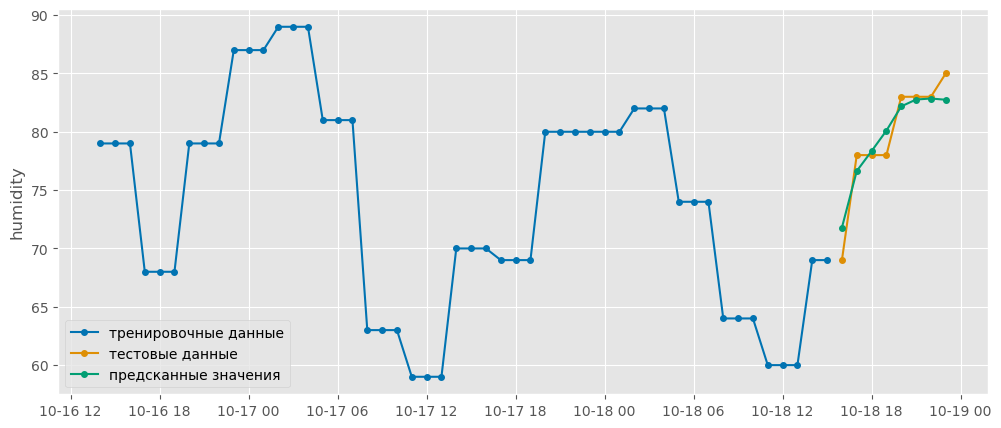

In [191]:
# автоподбор оказался более точным по всем метрикам
y_test = y1_test

y_test.index = pd.date_range(start="2024-10-18 16:00", end = '2024-10-18 23:00', freq="h").to_period()

# посмотрим на график 
fig, ax = plot_series(y1[-50:], y_test, y_pred, 
                      labels=["тренировочные данные",
                                "тестовые данные", 
                                "предсканные значения"])
ax.legend(loc='lower left')
ax.figure.set_size_inches(12, 5)

In [ ]:
# полученный прогноз в целом хорошо подстроился под тестовую выборку

In [202]:
#попробуем построить наивный прогноз на последние 8 наблюдений

from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(window_length = 24, strategy = 'mean')
forecaster.fit(y1)
y_pred = forecaster.predict(fh=fh)

print('MAE:', mean_absolute_error(y1_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y1_test, y_pred))
print('MSE:', mean_squared_error(y1_test, y_pred))
print('R2:', r2_score(y1_test, y_pred))

MAE: 8.156249999999996
MAPE: 0.10047682409419956
MSE: 76.76215277777771
R2: -2.339753757836692


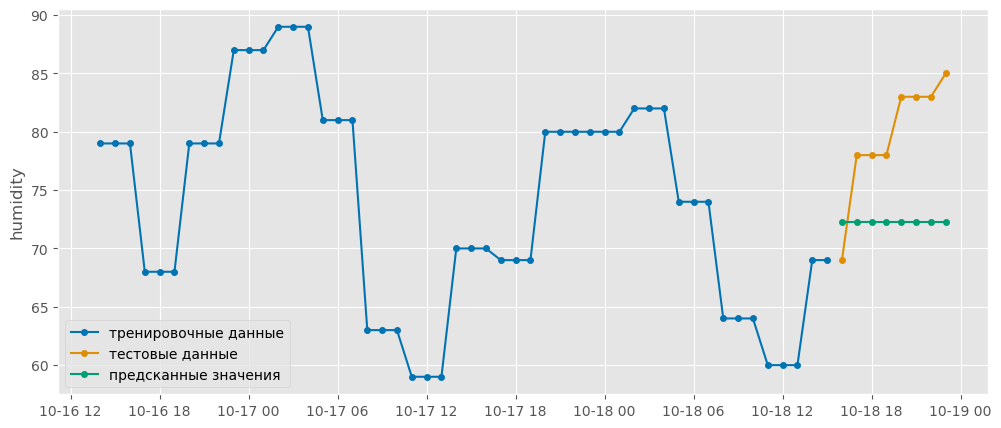

In [204]:
# посмотрим на график 
fig, ax = plot_series(y1[-50:], y_test, y_pred, 
                      labels=["тренировочные данные",
                                "тестовые данные", 
                                "предсканные значения"])
ax.legend(loc='lower left')
ax.figure.set_size_inches(12, 5)

In [ ]:
# полученный график прогноза сильно отклоняется от тестовой выборки

In [224]:
#попробуем подобрать ETS и построить прогноз на последние 8 наблюдений

from sktime.forecasting.ets import AutoETS
forecaster = AutoETS()
forecaster.fit(y1)
y_pred = forecaster.predict(fh = fh)

print('MAE:', mean_absolute_error(y1_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y1_test, y_pred))
print('MSE:', mean_squared_error(y1_test, y_pred))
print('R2:', r2_score(y1_test, y_pred))

MAE: 10.62500009
MAPE: 0.13005165571684468
MSE: 135.8750019125
R2: -4.911624828280082


In [216]:
cv = SlidingWindowSplitter(
    start_with_window=True,
    initial_window=300,
    fh=list(range(1, 9)),
    step_length= 24)

forecaster = AutoETS(sp=12)

param_grid = {
            'error':['add', 'mul'], 
            'trend':['add', 'mul', None]
             }

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    error_score='raise',
    scoring=mean_absolute_percentage_error
    )

gscv.fit(y1)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8],
                                                 initial_window=300,
                                                 step_length=24),
                        error_score='raise', forecaster=AutoETS(sp=12),
                        n_jobs=-1,
                        param_grid={'error': ['add', 'mul'],
                                    'trend': ['add', 'mul', None]},
                        scoring=<function mean_absolute_percentage_error at 0x1507b82c0>)

In [218]:
gscv.best_params_
# получились параметры ETS по умолчанию

{'error': 'add', 'trend': None}

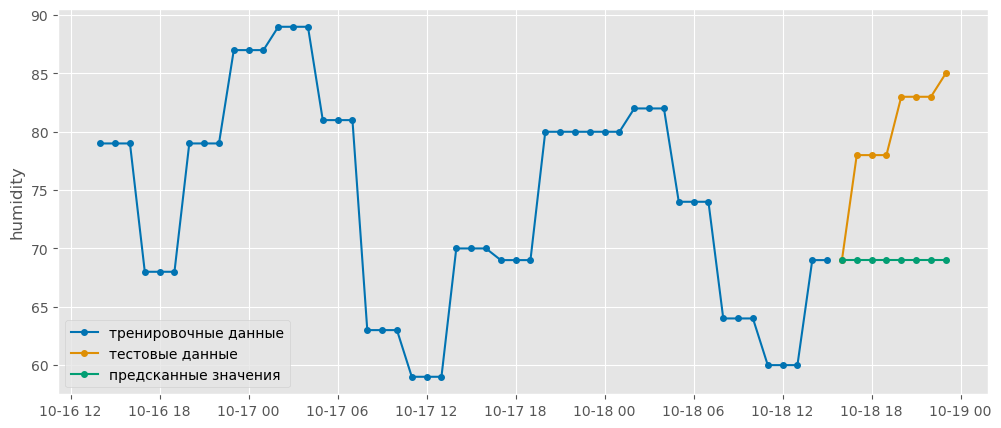

In [226]:
# посмотрим на график 
fig, ax = plot_series(y1[-50:], y_test, y_pred, 
                      labels=["тренировочные данные",
                                "тестовые данные", 
                                "предсканные значения"])
ax.legend(loc='lower left')
ax.figure.set_size_inches(12, 5)

In [ ]:
# полученный график прогноза сильно отклоняется от тестовой выборки, сильнее, чем прогноз ETS

# Выводы

1) ARIMA оказалась наиболее точной моделью для предсказания влажности на 8 часов вперед, что видно по метрикам MSE, MSE, MAPE, R2 и графикам прогнозных и реальных значений влажности.
2) ETS, учитывающая среднее за последние 24 часа, дает менее точный прогноз.
3) Наивный прогноз дает самый неточный прогноз.
4) AIMA, подобранная через GridSearch дала менее точный прогноз по сравнению с автоподором. Вероятно, необходимо также учитывать сезон при моделировании и определении тренировочной выборки, так как, например, начиная с марта влажность имеет больший разброс значений по сравнению с предыдущим полугодием.